# <center>Stock Prediction</center>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")



Using device: cpu


In [ ]:
START = "2010-01-01"
TODAY = dt.date.today().strftime("%Y-%m-%d")

import yfinance as yf

def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

# Load the data first
dataset = load_data('REGN')

# Now use it
dataset_cl = dataset['Close'].values


/tmp/ipython-input-12-1049945551.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, START, TODAY)
[*********************100%***********************]  1 of 1 completed


In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

In [ ]:
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)

X, y = processData(dataset_cl, 7)

In [ ]:
X_train, X_test = X[:int(X.shape[0]*0.80)], X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)], y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

3116
780
3116
780


In [ ]:
# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

 The model is a Recurrent Neural Network (RNN) using the LSTM (Long Short-Term Memory) architecture. We use 4 layers of LSTM with 128 hidden units each. Dropout layers are added between the LSTM layers to prevent overfitting, and a fully connected output layer is used to predict the next stock price. The model also supports bidirectional LSTM for improved accuracy.

In [ ]:

class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size,
                bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = 2 if bidirectional else 1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            bidirectional=True
        )
        self.out = nn.Linear(h_size * self.num_directions, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        r_out = r_out.view(-1, r_out.size(-1))  # Flatten the LSTM output
        outs = self.out(r_out)
        return outs, hidden_state

# class RNN(nn.Module):
#     def __init__(self, i_size, h_size, n_layers, o_size,
#                  dropout=0.3, bidirectional=True):
#         super(RNN, self).__init__()
#         self.num_directions = 2 if bidirectional else 1
#         self.rnn = nn.LSTM(
#             input_size=i_size,
#             hidden_size=h_size,
#             num_layers=n_layers,
#             dropout=dropout, //dropouts to avoid overfitting
#             bidirectional=True
#         )
#         self.out = nn.Linear(h_size * self.num_directions, o_size)

#     def forward(self, x, h_state):
#         r_out, hidden_state = self.rnn(x, h_state)
#         r_out = r_out.view(-1, r_out.size(-1))  # Flatten the LSTM output
#         outs = self.out(r_out)
#         return outs, hidden_state

In [ ]:
# Globals
INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128

In [ ]:
# Hyper parameters
learning_rate = 0.0003
num_epochs = 300

In [ ]:
# rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, dropout=0.3)
rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
rnn.to(device)

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()

hidden_state = None

In [ ]:
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, bidirectional=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=10)

In [ ]:
history = []
X_test_cuda = torch.tensor(X_test).float().to(device)
y_test_cuda = torch.tensor(y_test).float().to(device)

inputs_cuda = torch.tensor(X_train).float().to(device)
labels_cuda = torch.tensor(y_train).float().to(device)

In [ ]:
for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state)
    loss = criterion(output[:, 0].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch,
                                                       loss.item(),
                                                       test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch,
                                         loss.item()))
    history.append(loss.item())

epoch 0, loss 8.387336856685579e-05, eval loss 0.0012348185991868377
epoch 1, loss 8.383010572288185e-05
epoch 2, loss 8.378680649911985e-05
epoch 3, loss 8.374345634365454e-05
epoch 4, loss 8.370009163627401e-05
epoch 5, loss 8.365666144527495e-05
epoch 6, loss 8.361320215044543e-05
epoch 7, loss 8.356970647582784e-05
epoch 8, loss 8.352615259354934e-05
epoch 9, loss 8.348256960744038e-05
epoch 10, loss 8.343895751750097e-05
epoch 11, loss 8.339529449585825e-05
epoch 12, loss 8.335160237038508e-05
epoch 13, loss 8.330785931320861e-05
epoch 14, loss 8.32640944281593e-05
epoch 15, loss 8.322027861140668e-05
epoch 16, loss 8.317640458699316e-05
epoch 17, loss 8.313250873470679e-05
epoch 18, loss 8.308857650263235e-05
epoch 19, loss 8.304462244268507e-05
epoch 20, loss 8.300061745103449e-05, eval loss 0.0012094638077542186
epoch 21, loss 8.295653969980776e-05
epoch 22, loss 8.291246194858104e-05
epoch 23, loss 8.286831871373579e-05
epoch 24, loss 8.282416092697531e-05
epoch 25, loss 8.277

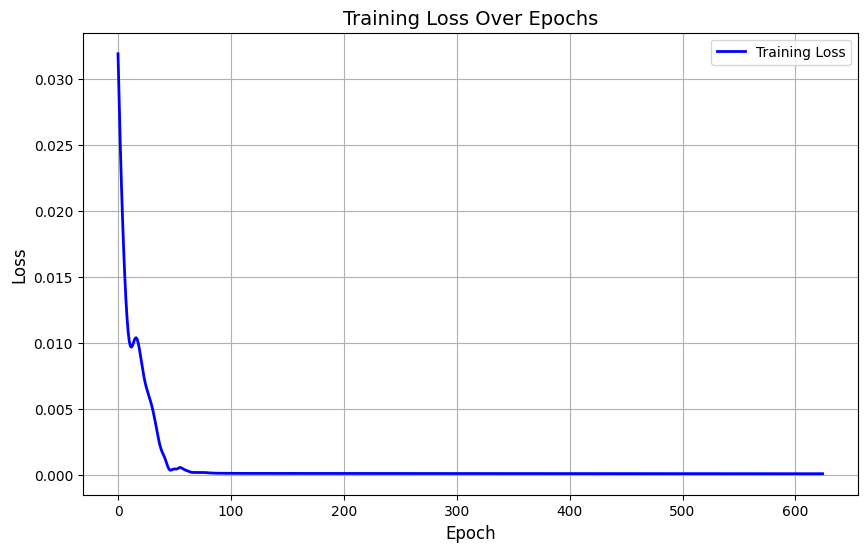

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history,
         label="Training Loss",
         color='blue',
         linewidth=2)
plt.title('Training Loss Over Epochs',
          fontsize=14)
plt.xlabel('Epoch',
           fontsize=12)
plt.ylabel('Loss',
           fontsize=12)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

This plot shows the training loss over the course of 300 epochs. We can observe that the training loss decreases significantly in the early epochs and gradually stabilizes after around 50 epochs. This indicates that the model is learning from the data and improving its predictions over time.

# Step 7: Visualizing the results

Finally, we visualize the model's predictions on the test set. The true stock prices are plotted against the predicted stock prices, allowing us to evaluate how well the model generalizes to unseen data. Additionally, we plot the model's fit on both the training and test sets in one graph to compare the performance on each set.

In [ ]:
rnn.eval()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()
y_test_inv = sc.inverse_transform(y_test.reshape(-1, 1))
test_predict_inv = sc.inverse_transform(test_predict_cpu.reshape(-1, 1))

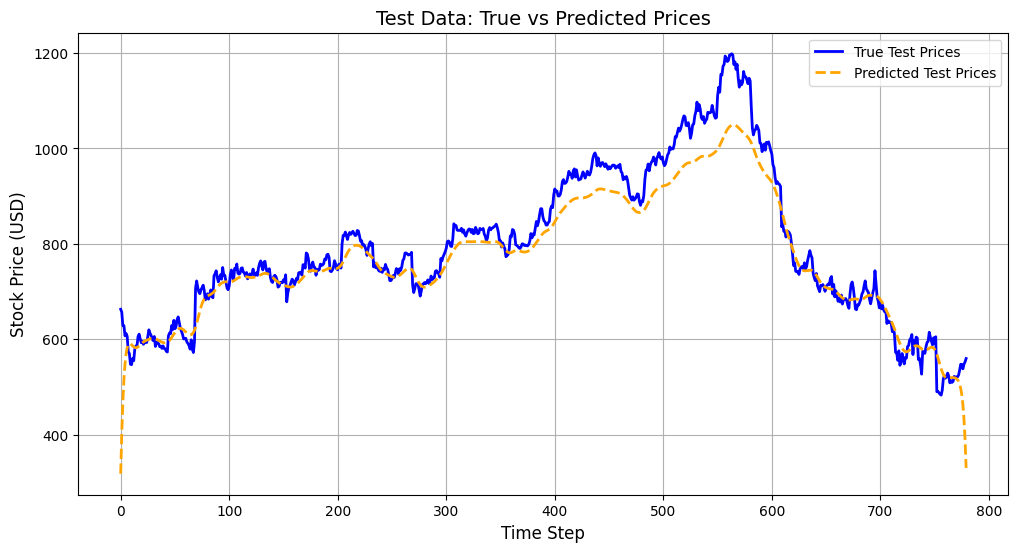

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv,
         label='True Test Prices',
         color='blue',
         linewidth=2)
plt.plot(test_predict_inv,
         label='Predicted Test Prices',
         color='orange',
         linestyle='--',
         linewidth=2)
plt.title('Test Data: True vs Predicted Prices',
          fontsize=14)
plt.xlabel('Time Step',
           fontsize=12)
plt.ylabel('Stock Price (USD)',
           fontsize=12)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

This plot compares the true stock prices (blue line) and the predicted prices (orange dashed line) on the test set. Ideally, the two lines should closely follow each other if the model performs well. In this case, we can see that the predicted prices follow the general trend of the true prices, but there is some deviation in certain areas, indicating room for improvement.

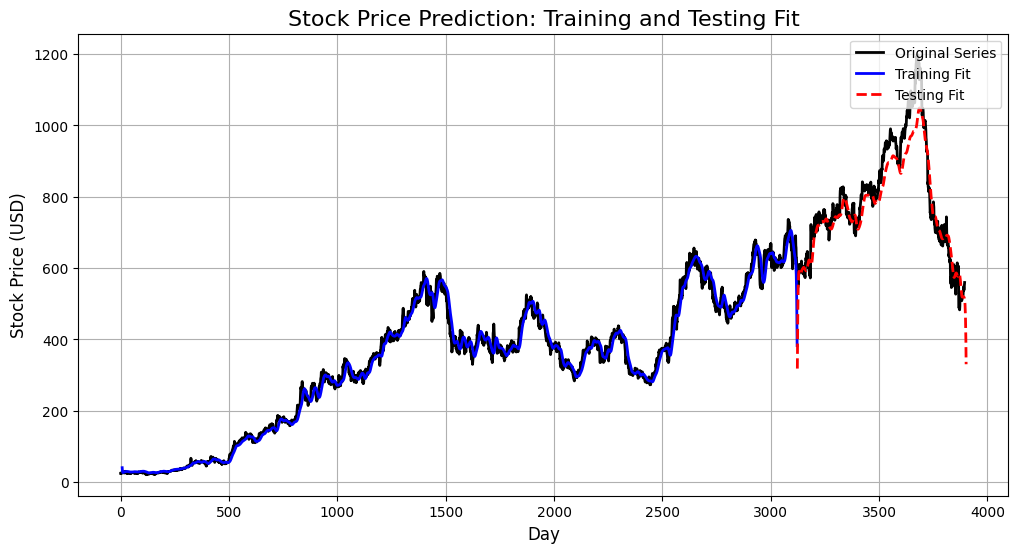

In [ ]:
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()
train_pred_inv = sc.inverse_transform(train_pred_cpu.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(sc.inverse_transform(y.reshape(-1, 1)),
         label='Original Series',
         color='black',
         linewidth=2)

split_pt = int(X.shape[0] * 0.80) + 7
plt.plot(np.arange(7, split_pt, 1),
         train_pred_inv,
         color='blue',
         label='Training Fit',
         linewidth=2)

plt.plot(np.arange(split_pt, split_pt + len(test_predict_inv), 1),
         test_predict_inv,
         color='red',
         linestyle='--',
         label='Testing Fit',
         linewidth=2)

plt.title('Stock Price Prediction: Training and Testing Fit', fontsize=16)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

This plot compares the model's fit on both the training set (blue line) and the test set (red dashed line), against the original stock price series (black line). The blue line closely follows the black line, indicating that the model fits the training data well. However, the red dashed line, which represents the test set, shows some deviation from the black line, suggesting that the model is not generalizing as well to unseen data.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_test_inv = sc.inverse_transform(y_test.reshape(-1, 1))
test_predict_cpu = test_output.cpu().detach().numpy()
test_predict_inv = sc.inverse_transform(test_predict_cpu.reshape(-1, 1))

mse = mean_squared_error(y_test_inv, test_predict_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, test_predict_inv)
r2 = r2_score(y_test_inv, test_predict_inv)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')


Mean Squared Error (MSE): 2416.667798365342
Root Mean Squared Error (RMSE): 49.15961552296094
Mean Absolute Error (MAE): 33.85889462202023
R² Score: 0.9022852238572796
